# Machine Learning in Python - Project 1

Due Friday, March 8th by 4 pm.

*Include contributors names in notebook metadata or here*

## Setup

*Install any packages here and load data*

In [1]:
# Add any additional libraries or submodules below

# Data libraries
import pandas as pd
import numpy as np
# !pip install statsmodels INSTALL
import statsmodels.api as sm
# !pip install openpyxl
import openpyxl
from scipy import stats

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80
sns.color_palette("hls", 12)

# sklearn modules
import sklearn
from sklearn.pipeline import Pipeline
from sklearn import preprocessing as pp
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import Ridge
from sklearn.compose import ColumnTransformer


/tmp/ipykernel_2045/3968627645.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Load data in easyshare.csv
easy_share = pd.read_csv("easyshare.csv")
inc_lvl=pd.read_excel("inc_lvl_countries.xlsx",sheet_name="List of economies")

In [3]:
def get_coefs(m):
    """Returns the model coefficients from a Scikit-learn model object as an array,
    includes the intercept if available.
    """
    
    # If pipeline, use the last step as the model
    if (isinstance(m, sklearn.pipeline.Pipeline)):
        m = m.steps[-1][1]
    
    
    if m.intercept_ is None:
        return m.coef_
    
    return np.concatenate([[m.intercept_], m.coef_])


def model_fit(m, X, y, plot = False):
    """Returns the mean squared error, root mean squared error and R^2 value of a fitted model based 
    on provided X and y values.
    
    Args:
        m: sklearn model object
        X: model matrix to use for prediction
        y: outcome vector to use to calculating rmse and residuals
        plot: boolean value, should fit plots be shown 
    """
    
    y_hat = m.predict(X)
    MSE = mean_squared_error(y, y_hat)
    RMSE = np.sqrt(mean_squared_error(y, y_hat))
    Rsqr = r2_score(y, y_hat)
    
    Metrics = (round(MSE, 4), round(RMSE, 4), round(Rsqr, 4))
    
    res = pd.DataFrame(
        data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    
    if plot:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(121)
        sns.lineplot(x='y', y='y_hat', color="grey", data =  pd.DataFrame(data={'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Actual vs Fitted plot")
        
        plt.subplot(122)
        sns.scatterplot(x='y_hat', y='resid', data=res).set_title("Fitted vs Residual plot")
        plt.hlines(y=0, xmin=np.min(y), xmax=np.max(y), linestyles='dashed', alpha=0.3, colors="black")
        
        plt.subplots_adjust(left=0.0)
        
        plt.suptitle("Model (MSE, RMSE, Rsqr) = " + str(Metrics), fontsize=14)
        plt.show()
    
    return Metrics

# Introduction

***This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a professional body (e.g. European Union, Governments, Health Institutes and/or Charities on dementia and ageing). If you use any additional data sources, you should introduce them here and discuss why they were included.***

***Briefly outline the approaches being used and the conclusions that you are able to draw.***

The world's population distribution is shifting towards the predominance of ageing people, following continuous years of scientific developments that have positively impacted human beings' life expectancy. In 2018, the number of people in the world aged 65 or above surpassed people under 5 years old for the first time in history<sup>1</sup>. Moreover, by 2030, 1 out of 6 people are expected to be 60 or above and the number of people aged 80 or above are expected to triple by 2050 -versus 2020-<sup>2</sup>. These statistics reflect an ageing world population, as is consistent with the observed trend in life expectancy, which was recorded at around 73 years old for 2023, representing a gain of 10 years of life for the world's average person today versus 40 years ago.

Although these demographic figures have an encouraging flavour for humankind, the progression of the average human lifetime in years does not come without a cost. One of the adversities raised by this overall positive scenario for humanity is the prevalence of costly age-related diseases, like dementia. According to the World Health Organisation (WHO), currently over 55 million people live with dementia and this number is expected to almost triple by 2050<sup>3</sup>. In 2020, the annual cost of dementia was estimated at a staggering figure of US$818 billion and is expected to reach US$2 trillion by 2030, mostly due to familiar and social costs (not strictly medical care)<sup>3</sup>.

Fortunately, these projections are not unavoidable. As previous studies have shown (Livingstone et al. (2017), Livingstone et al. (2020), GBD 2016 Dementia Collaborators (2016)), there are over nine modifiable risks for dementia, which include less education, smoking, obesity, physical inactivity, low social contact, excessive alcohol consumption, among others. For this reason, the European Union seeks to better understand how these factors' impact on dementia severity, as this is key to develop prevention policies at a country, regional and worldwide level to reduce the social costs of this disease. 

In that regard, the purpose of this study is to adequately estimate the relationship between dementia severity and diverse demographic and health factors adding to the current academic literature on the subject, and from this estimation suggest policy areas that may be wise to focus by both the European Union and other governmental and non-governmental institutions. For this objective, we use the easySHARE data which is a simplified dataset of the panel data generated from the distinct waves (surveys in time) of the Survey of Health, Ageing and Retirement in Europe (SHARE). This dataset aims to provide data on European individuals as they age and their environment. The easySHARE database to use contains 22 variables, with observations recorded at a individual level, with one observation per individual (although different observations may correspond to different waves of SHARE).

This study will explore supervised machine learning methods, focusing specifically on estimating a regression model for easySHARE individuals' cognitive score, which will be used as a proxy variable for dementia severity, using modifiable risk factors identified by previous literature and exploring new posible factors of interest.

*“This paper uses data from the generated easySHARE data set (DOI: 10.6103/SHARE.easy.800), see Gruber et al. (2014) for methodological details. The easySHARE release 8.0.0 is based on SHARE Waves 1, 2, 3 (SHARELIFE), 4, 5, 6, 7 and 8 (DOIs: 10.6103/SHARE.w1.800, 10.6103/SHARE.w2.800, 10.6103/SHARE.w3.800, 10.6103/SHARE.w4.800,10.6103/SHARE.w5.800, 10.6103/SHARE.w6.800, 10.6103/SHARE.w7.800, 10.6103/SHARE.w8.800)”*

<sup>1</sup> "World Population Prospects 2022, Summary of Results", United Nations, accessed February 29, 2024, *https://www.un.org/development/desa/pd/sites/www.un.org.development.desa.pd/files/wpp2022_summary_of_results.pdf*.

<sup>2</sup> "Ageing and Health", World Health Organization, accessed February 29, 2024, *https://www.who.int/news-room/fact-sheets/detail/ageing-and-health#:~:text=Every%20country%20in%20the%20world,in%202020%20to%201.4%20billion.*.

<sup>3</sup> "Dementia", World Health Organization, accessed February 29, 2024, *https://www.who.int/news-room/facts-in-pictures/detail/dementia*.

# Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling. Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. Think carefully about whether each plot needs to be included in your final draft - your report should include figures but they should be as focused and impactful as possible.*

*You should also split your data into training and testing sets, ideally before you look to much into the features and relationships with the target*

*Additionally, this section should also implement and describe any preprocessing / feature engineering of the data. Specifically, this should be any code that you use to generate new columns in the data frame `d`. Feature engineering that will be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

*If you decide to extract additional features from the full data (easyshare_all.csv), describe these variables here.*

*All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.*

In [4]:
# Joining Datasets
    # Renaming column for join
inc_lvl = inc_lvl.rename(columns={'Country Code': 'country'})
    # Left join
df = pd.merge(easy_share, inc_lvl, on='country', how='left')
df = df.drop(columns=['Economy', 'Income_Group'])
df = df.rename(columns={'Short_Income_Group': 'country_inc'})

    # See data
#df.head(5)

In [5]:
    # Visualize numerical columns in data
df.describe(include = [np.number]).round(2)

,int_year,wave,country,country_mod,female,age,birth_country,citizenship,isced1997_r,eduyears_mod,...,bmi2,smoking,ever_smoked,br010_mod,br015_,casp,chronic_mod,sp008_,ch001_,cogscore
count,97372.00,97372.00,97372.00,97372.00,97372.00,97372.00,97170.00,97281.00,97372.00,84532.00,...,94686.00,96887.00,97116.00,79210.00,97113.00,84065.00,97283.00,83175.00,96928.00,97372.00
mean,2010.47,3.79,24.27,384.95,0.54,67.94,398.30,391.76,2.66,10.43,...,2.85,4.34,3.26,3.35,2.67,36.74,1.31,3.98,2.17,11.97
std,4.63,2.15,12.30,229.26,0.50,8.86,237.54,232.97,1.49,4.26,...,0.76,1.48,1.98,2.24,1.33,6.46,1.27,1.74,1.40,4.18
min,2004.00,1.00,11.00,40.00,0.00,55.10,2.00,4.00,0.00,0.00,...,1.00,1.00,1.00,1.00,1.00,12.00,0.00,1.00,0.00,0.00
25%,2006.00,2.00,15.00,208.00,0.00,60.50,208.00,208.00,1.00,8.00,...,2.00,5.00,1.00,1.00,1.00,32.00,0.00,1.00,1.00,9.00
50%,2011.00,4.00,20.00,300.00,1.00,66.60,348.00,348.00,3.00,11.00,...,3.00,5.00,5.00,3.00,3.00,37.00,1.00,5.00,2.00,12.00
75%,2013.00,5.00,31.00,616.00,1.00,74.20,642.00,620.00,3.00,13.00,...,3.00,5.00,5.00,5.00,4.00,42.00,2.00,5.00,3.00,15.00
max,2020.00,8.00,63.00,756.00,1.00,111.60,1101.00,1132.00,6.00,30.00,...,4.00,5.00,5.00,7.00,4.00,48.00,9.00,5.00,17.00,26.00


In [6]:
    # Visualize text columns in data
df.describe(include = ['O'])

,mergeid,country_inc
count,97372,97372
unique,97372,2
top,AT-000674-01,H_inc
freq,1,96531


Clearly, country income level according to the World Bank will not be a useful variable due to the fact our easySHARE data circumscribes to Europe, for which all countries, with only one exception, are categorized as High Income, thus creating a variable with virtually no variability to relate to our cognitive score variable.

Text(0.5, 0.98, 'Histograms of Non-Categorical Variables in easySHARE')

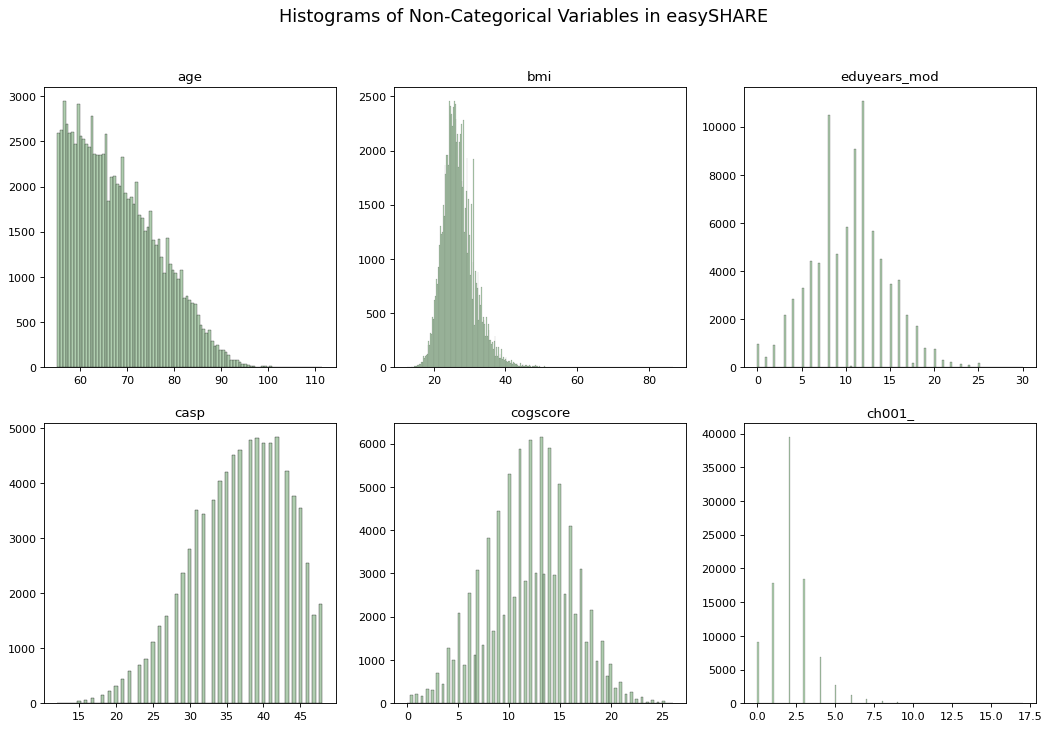

In [7]:
# Initial Data Exploration
#df.info()

    ## There are no missing values (unanswered, etc) according to the codes listed 
    ## in the data description file.

# List of columns per type of variable
    # ID variables
id_vars = ['int_year','wave','mergeid']
    # Non-categorical variables
numerical_vars = ['age','bmi','eduyears_mod','casp','cogscore','ch001_']
    # Binary variables
bin_vars = ['female','smoking','ever_smoked','sp008_']
    # Categorical variables (n>2)
cat_vars = np.setdiff1d(df.columns,id_vars+numerical_vars+bin_vars).tolist()
#len(cat_vars+bin_vars+numerical_vars+id_vars)==len(df.columns) # Checking no variables are missing
# Explore distribution of non-categorical variables

# Explore variable distributions through histograms
fig, ax = plt.subplots(figsize = (16, 10))
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])
for n, col in enumerate(numerical_vars):
    plt.subplot(2,3, n+1)
    a=sns.histplot(df[col],ax = plt.gca(),color='#95bd95')
    a.set(xlabel=None,ylabel=None)
    a.set_facecolor('white')
    plt.title(col)
plt.suptitle("Histograms of Non-Categorical Variables in easySHARE", fontsize=16)
#print("What is happening with cogscore?")

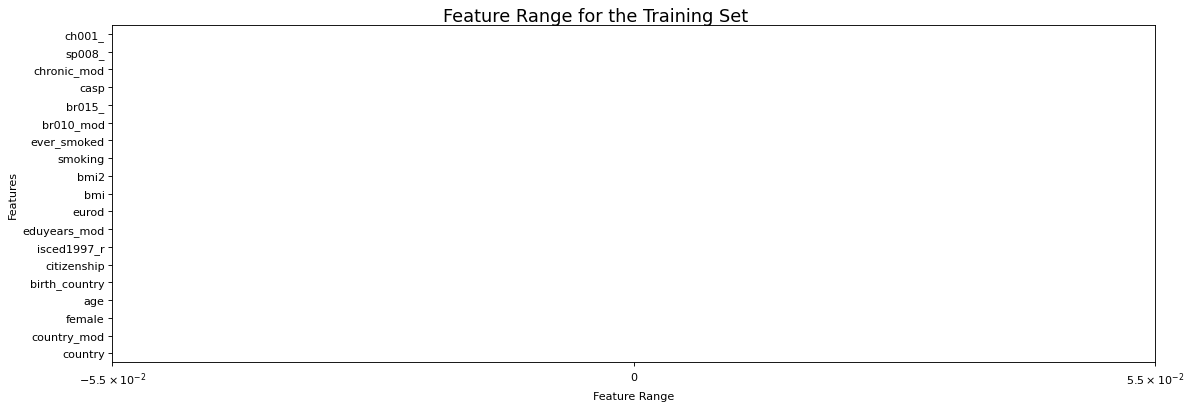

In [8]:
# Investigating the range of features in our data set
df_numerical = df.drop(['mergeid','country_inc'], axis = 1)
df_ = df_numerical.drop(['int_year', 'wave',], axis = 1)
features = list(df_.columns)
X = df_.values
fig, ax = plt.subplots(figsize=(15,5))

plt.boxplot(X[:,:-1], vert = False) 
#ax.set_xlim(-1,10000)
plt.xscale("symlog") 
plt.ylabel("Features") 
plt.xlabel("Feature Range")
ax.set_yticklabels(features[:-1])
plt.tight_layout()

plt.suptitle("Feature Range for the Training Set", fontsize=16,y=1.015)
plt.show()

>- From the histograms and general boxplots for feature range exploration, we can see that the features all have very different scales, thus we identify that standardization will be necessary as part of our feature engineering.
>- Some of the histograms are heavy-tailed: they extend farther to the right/left of the median than to the left/right. This may make it a bit harder for some algorithms to detect patterns. 
>- We will try transforming these attributes later on to have more bell-shaped distributions.

/usr/local/python/3.10.13/lib/python3.10/site-packages/statsmodels/graphics/gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


Text(0.5, 0.98, 'Q-Q Plots of Non-Categorical Variables of easySHARE')

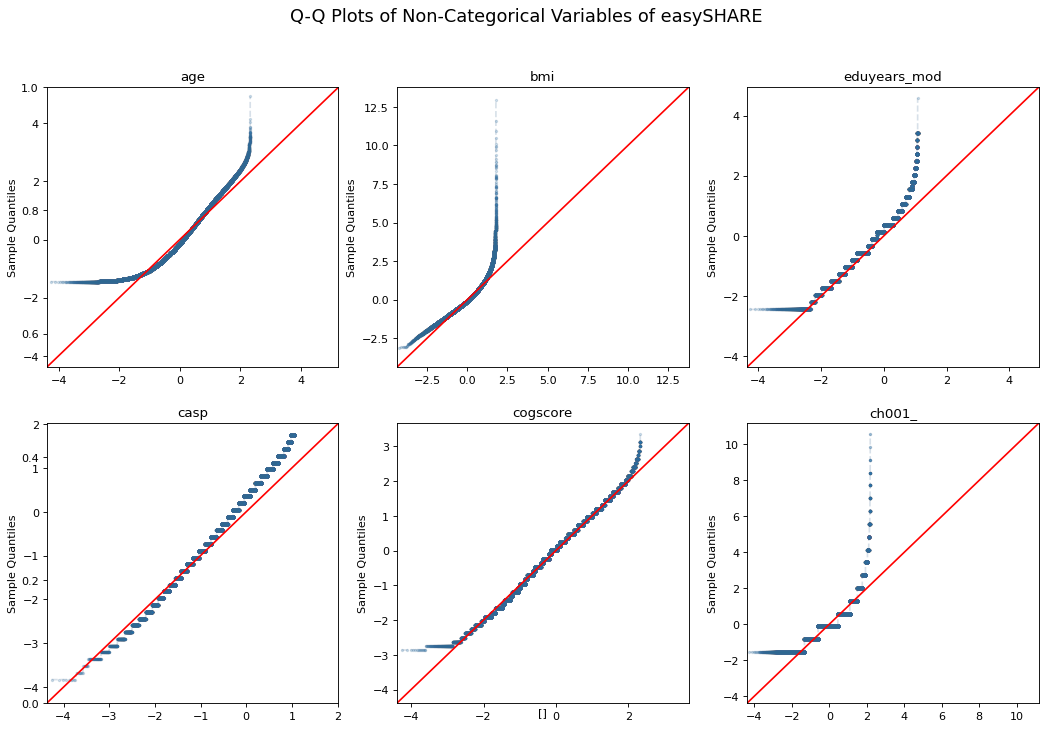

In [9]:
# Now we want to normalize the non-categorical values and compare their distributions
# with a normal using a Q-Q Plot. 

    # Standardization
nc_df = df[numerical_vars].values #returns a numpy array
nc_df_std = pp.StandardScaler().fit_transform(nc_df)
nc_df_std = pd.DataFrame(nc_df_std,columns=numerical_vars)

fig, axs = plt.subplots(figsize=(16, 10))
axs.set_frame_on(False)
axs.set_xticks([])
axs.set_xlabel([])
#axs.set_yticks([])
for n, col in enumerate(numerical_vars):
    plt.subplot(2,3,n+1)
    sm.qqplot(nc_df_std[col], ax=plt.gca(),line='45',fit=False,
                **{'markersize':2, 'alpha':0.2,'markeredgecolor':'#3a6791',
                'linestyle':'dashed','color':'#3a6791'})
    plt.title(col)
    plt.xlabel('')
fig.suptitle('Q-Q Plots of Non-Categorical Variables of easySHARE', fontsize=16)


 *THIS TEXT IS NOT GOOD ENOUGH FOR REPORT, HERE FOR REFERENCE*
 
Variables casp and cogscore are relatively normal-looking, with the exception of caps in their extremes. However, the rest of our variables seem to have a strong right-skew and, particularly *bmi*, *eduyears_mod* and *ch001_* seem to have important outliers, which we will explore later in this paper.

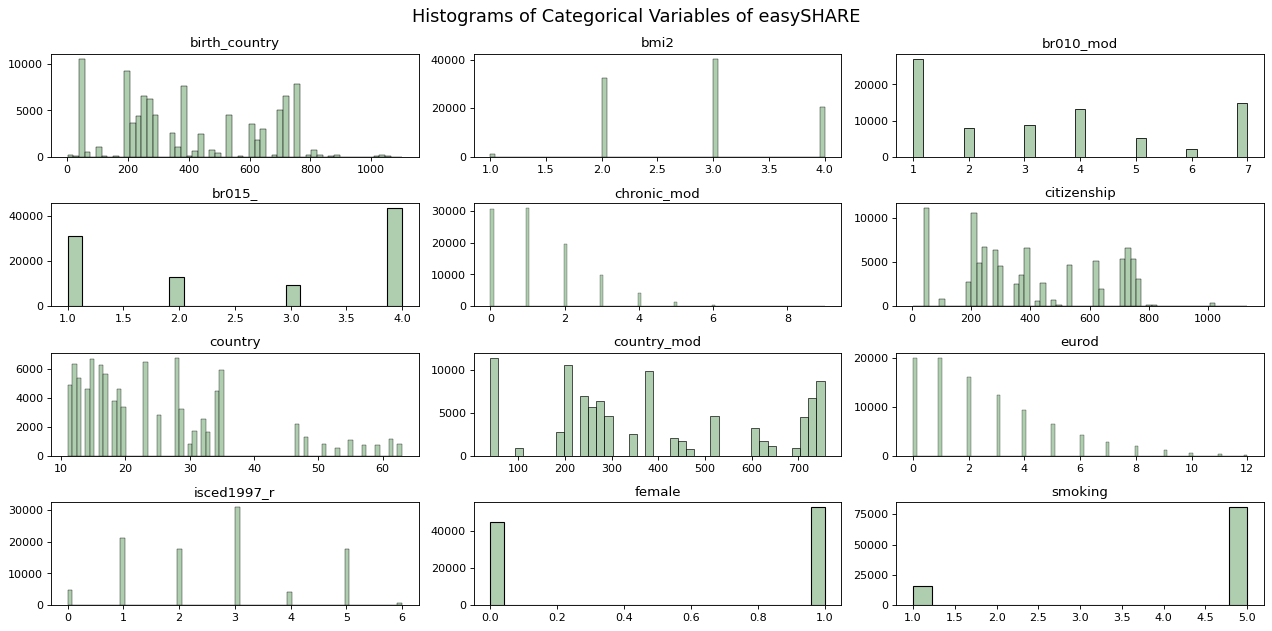

In [10]:
cat_v_orig= [x for x in cat_vars if x != "country_inc"]
cat_bin=cat_v_orig+bin_vars
cat_bin_df=df[cat_bin]

fig, axes = plt.subplots(figsize = (16, 8), ncols = 3, nrows=4, sharex = False)
axes = axes.flatten()
for i, ax in enumerate(axes):
    sns.histplot(data=cat_bin_df,x=cat_bin[i], ax = ax,color='#95bd95') 
    ax.set_title(cat_bin[i])
    ax.set_ylabel("")
    ax.set_xlabel("")
    
fig.suptitle('Histograms of Categorical Variables of easySHARE', fontsize=16)
plt.tight_layout()

Similarly, we can observe important skewness is the variables *eurod* and *chronic_mod*. This suggests if we wanted to include *eurod*, it would likely be more beneficial to include use *isced1997_r* with OneHotEncoding. Regarding *chronic_mod*, we will address the treatment of this variable further down, if necessary.

Features with outliers: age, eduyears_mod, eurod, bmi, casp, ch001_. What should we drop?
Discussion on handling ordinal categorical vars: https://stats.stackexchange.com/questions/522216/ordinal-variable-in-multiple-linear-regression-model,
 we may have to convert with OneHotEncoder.


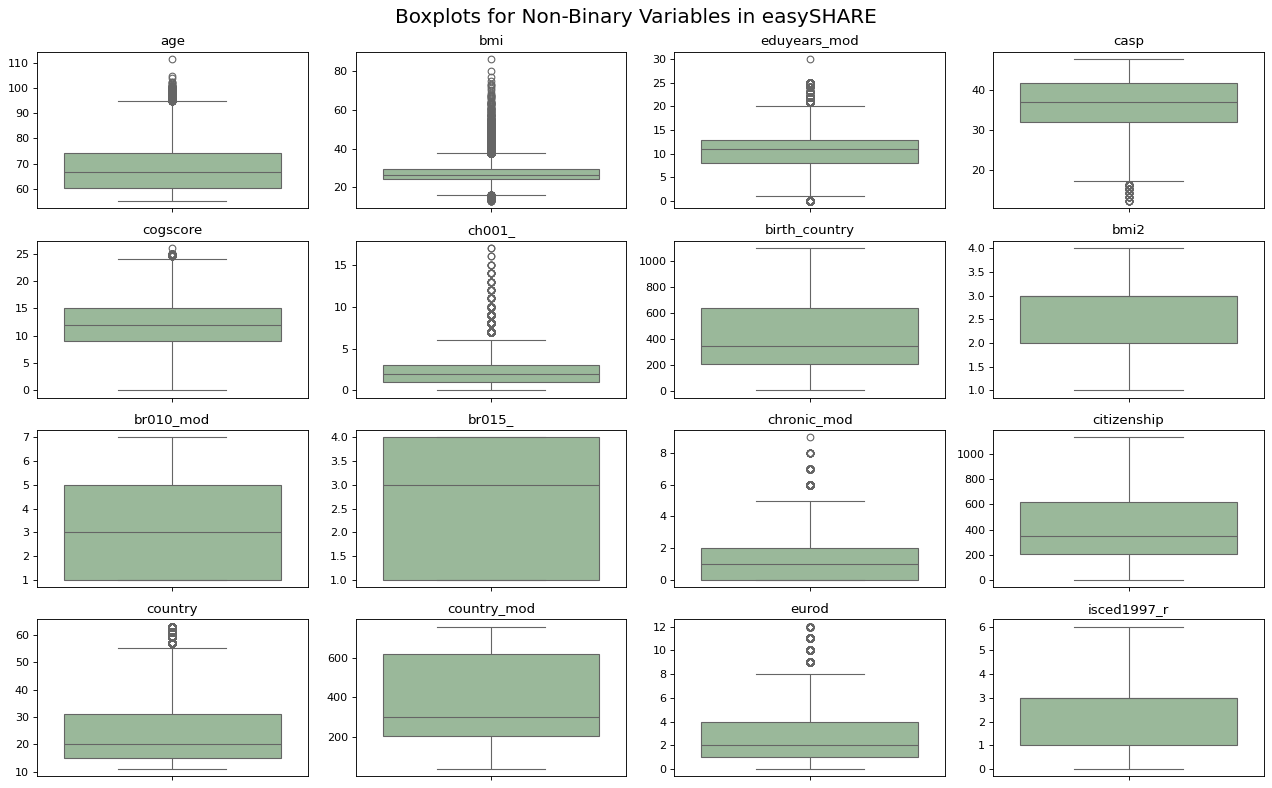

In [11]:

lst_cols=numerical_vars+cat_vars
lst_cols.remove('country_inc')
X=df[lst_cols].values

fig, axes = plt.subplots(figsize = (16, 10), ncols = 4, nrows=4, sharex = True)
axes = axes.flatten()

for i, ax in enumerate(axes):
    sns.boxplot(y = X[:,i], ax = ax,color='#95bd95') 
    ax.set_title(lst_cols[i])
    ax.set_ylabel("")
    
plt.suptitle("Boxplots for Non-Binary Variables in easySHARE", fontsize=18)
plt.tight_layout()

print("Features with outliers: age, eduyears_mod, eurod, bmi, casp, ch001_. What should we drop?")
print("Discussion on handling ordinal categorical vars: https://stats.stackexchange.com/questions/522216/ordinal-variable-in-multiple-linear-regression-model,\n we may have to convert with OneHotEncoder.")

The outlier analysis showcases several variables have outliers to handle. Nonetheless, the methods to be applied to handle these must make a distinction between the variables that are categorical and those that are not. For instance, perhaps the variables *chronic_mod* (number of chronic diseases), *ch001_* (number of children) and *eduyears_mod* (years of education) could undergo Winsorization to handle the outliers. In addition to these suggestions, it could be beneficial to use *bmi2* (categorical variable for bmi) in our subsequent models, due both to reason of relevant interpretation and outlier prevalence in *bmi*. For interpretation purposes, it would also be useful to categorize *country_mod* by income level.

In [64]:
# Winsorizing eduyears_mod, chronic_mod and ch001_
up_lim_edu=df['eduyears_mod'].quantile(0.99)
lo_lim_edu=df['eduyears_mod'].quantile(0.01)

up_lim_chr=df['chronic_mod'].quantile(0.99)
lo_lim_chr=df['chronic_mod'].quantile(0.01)

up_lim_chi=df['ch001_'].quantile(0.99)
lo_lim_chi=df['ch001_'].quantile(0.01)

cap_df = df.copy()

cap_df['eduyears_mod']=np.where(cap_df['eduyears_mod']>=up_lim_edu,
                        up_lim_edu,
                        np.where(cap_df['eduyears_mod']<=lo_lim_edu,
                        lo_lim_edu,
                        cap_df['eduyears_mod']))

cap_df['chronic_mod']=np.where(cap_df['chronic_mod']>=up_lim_chr,
                        up_lim_chr,
                        np.where(cap_df['chronic_mod']<=lo_lim_chr,
                        lo_lim_chr,
                        cap_df['chronic_mod']))

cap_df['ch001_']=np.where(cap_df['ch001_']>=up_lim_chi,
                        up_lim_chi,
                        np.where(cap_df['ch001_']<=lo_lim_chi,
                        lo_lim_chi,
                        cap_df['ch001_']))



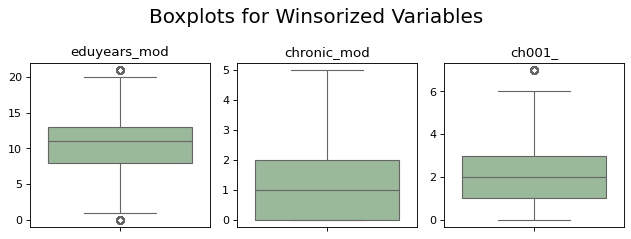

In [13]:
# Boxplots after winsorization
wns_cols=['eduyears_mod','chronic_mod','ch001_']
fig, axes = plt.subplots(figsize = (8, 3), ncols = 3, nrows=1, sharex = True)
axes = axes.flatten()
wns_vals=cap_df[wns_cols].values

for i, ax in enumerate(axes):
    sns.boxplot(y = wns_vals[:,i], ax = ax,color='#95bd95') 
    ax.set_title(wns_cols[i])
    ax.set_ylabel("")
    
plt.suptitle("Boxplots for Winsorized Variables", fontsize=18)
plt.tight_layout()


Text(0.5, 0.98, 'Heatmap of Numerical and Non-Binary Categorical Variables in easySHARE')

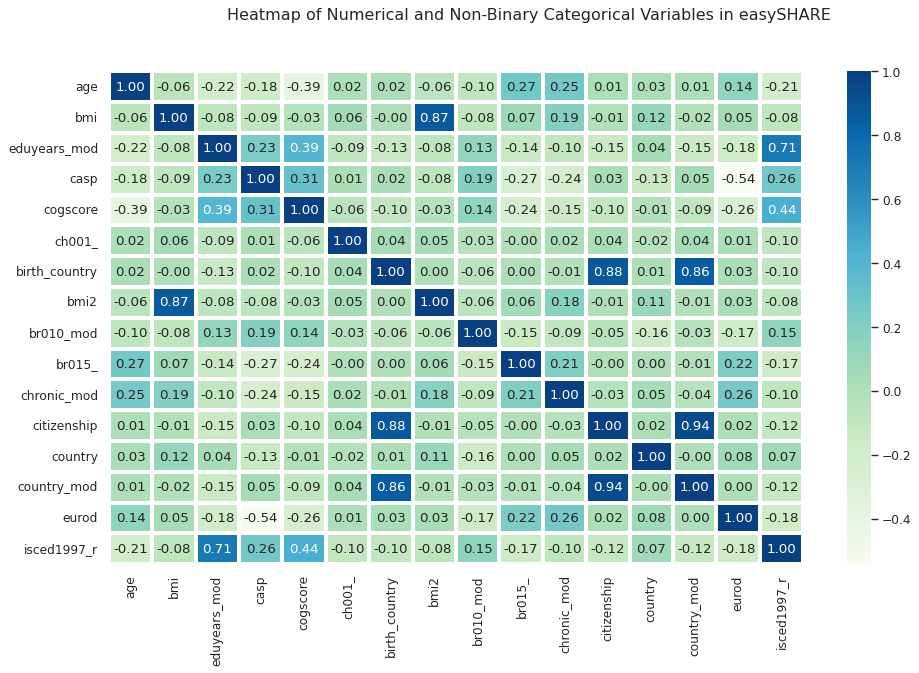

In [14]:
# Plot a heat map to check if any of the features are correlated
sns.set(rc={'figure.figsize': (14, 8)})
sns.heatmap(df[lst_cols].corr(),cmap="GnBu", annot = True, fmt = '.2f',  linewidths = 2)
plt.suptitle('Heatmap of Numerical and Non-Binary Categorical Variables in easySHARE', y=0.98)


 *THIS TEXT IS NOT GOOD ENOUGH FOR REPORT, HERE FOR REFERENCE*

As expected, *bith_country*, *country_mod* and *citizenship* have a high positive correlation; as do *eduyears_mod* and *isced1997_r* (ISCED-97 coding of education level), and *bmi* and *bmi2*. This serves as a reminder to choose only one of the representation of demographic factors (continuos vs categorical). Additionally, *eurod* (depression level) and *casp* (quality of life) seem to have medium correlation. Other than this, factors do not seem to have high correlation amongst themselves, thus, it is not evident from the start that any of the variables could be dropped and represented by another.

In [65]:
# DATA CLEANING

# Drop the null values
cap_df = cap_df.dropna()

# We have no duplicated values :)
cap_df.duplicated().sum()

# Check null values per column
cap_df.isna().sum(axis = 0)



mergeid          0
int_year         0
wave             0
country          0
country_mod      0
female           0
age              0
birth_country    0
citizenship      0
isced1997_r      0
eduyears_mod     0
eurod            0
bmi              0
bmi2             0
smoking          0
ever_smoked      0
br010_mod        0
br015_           0
casp             0
chronic_mod      0
sp008_           0
ch001_           0
cogscore         0
country_inc      0
dtype: int64

Text(0.5, 0.98, 'Heatmap of Binary Categorical Variables and Cogscore in easySHARE')

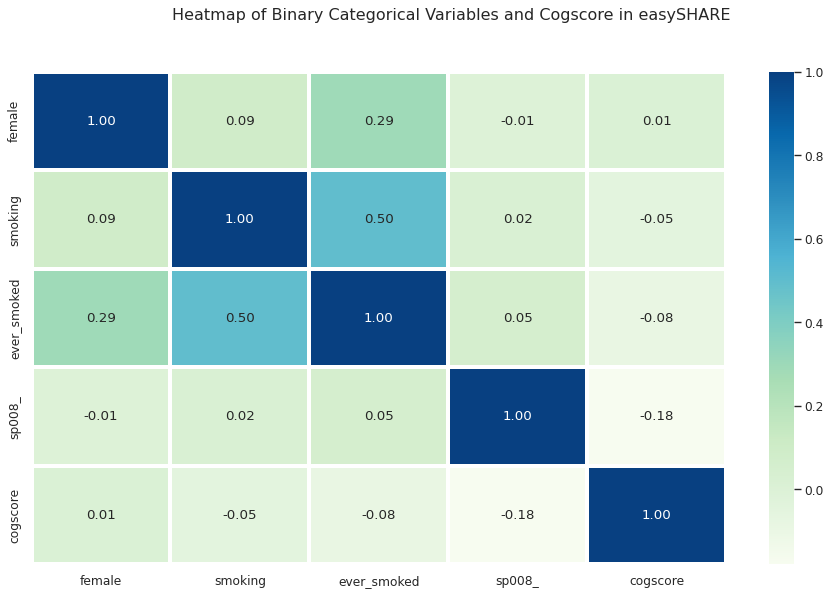

In [16]:
# Plot a heat map to check if any of the features are correlated
sns.set(rc={'figure.figsize': (14, 8)})
lst_bin_cs=bin_vars+['cogscore']
sns.heatmap(cap_df[lst_bin_cs].corr(),cmap="GnBu", annot = True, fmt = '.2f',  linewidths = 2)
plt.suptitle('Heatmap of Binary Categorical Variables and Cogscore in easySHARE', y=0.98)


Text(0.5, 1.015, 'Scatter Plot of Non-Binary Categorical Variables to Cognitive Score')

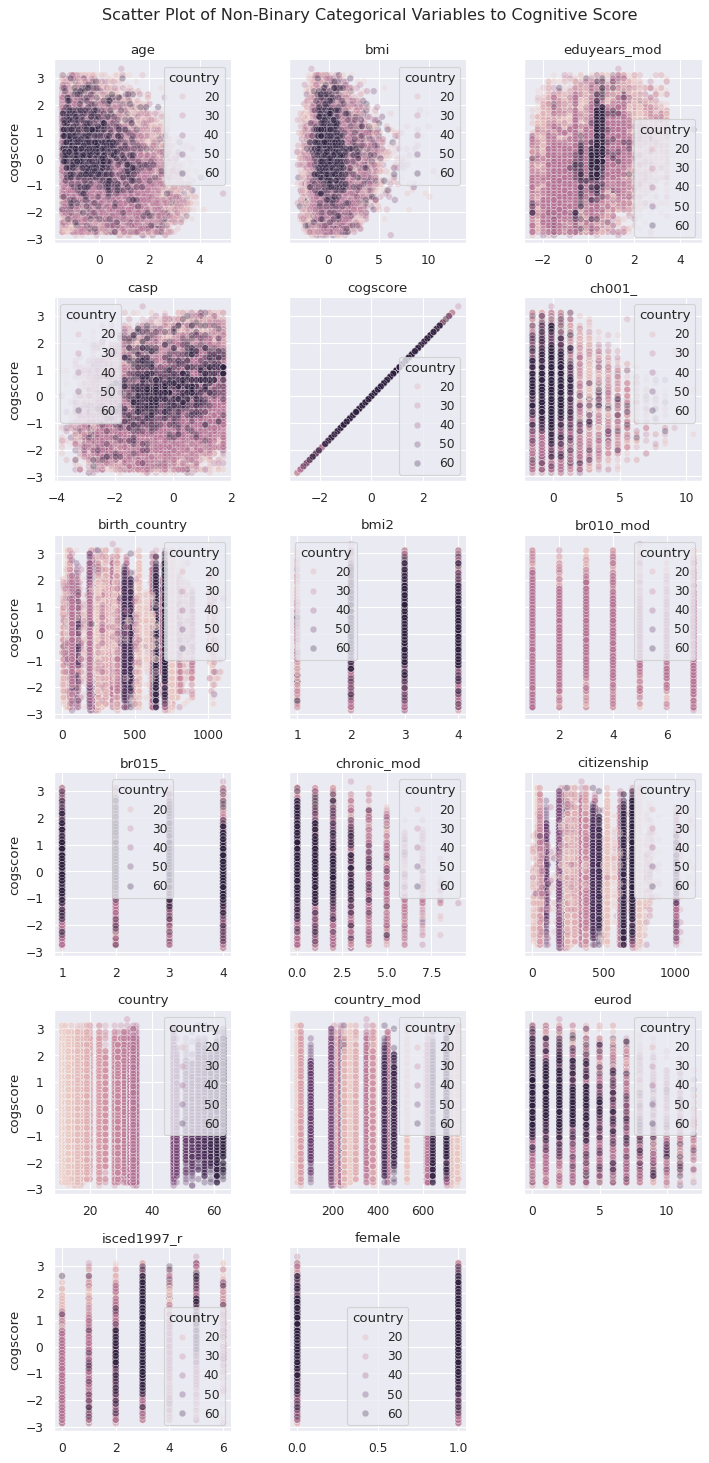

In [54]:
# "Pairplot" equivalent
cat_cols_f=cat_vars+['female']
cat_cols_f.remove('country_inc')
lst_cols_f=lst_cols+['female']
std_df = pd.concat([nc_df_std, df[cat_cols_f]], axis="columns")
    # Creating Facet Grid
g = sns.FacetGrid(pd.DataFrame(lst_cols_f), col=0, col_wrap=3, sharex=False)
    # Plotting scatterplots
for ax, varx in zip(g.axes, lst_cols_f):
    sns.scatterplot(data=std_df, x=varx, y="cogscore", ax=ax,
    alpha=0.3)
    ax.set_xlabel("")

g.set_titles('{col_name}')
plt.suptitle('Scatter Plot of Non-Binary Categorical Variables to Cognitive Score', y=1.015)
# g.tight_layout()

At first hand, no obvious relationships are aparent between our possible continuous independent variables and *cogscore*. 

In [1]:
# What if we filter for one wave?
wave_gr = cap_df.groupby("wave") 
  
# What if we filter for one wave?
country_gr = cap_df.groupby("country_mod") 
  # count the observations 
wave_gr.count()
# Check which wave has clearer patterns?

# count the observations 
#country_gr.count() 
# country 203 has most obs.
#cap_df["country_mod"].dtype

NameError: name 'cap_df' is not defined

Text(0.5, 1.015, 'Scatter Plot with Wave Hue')

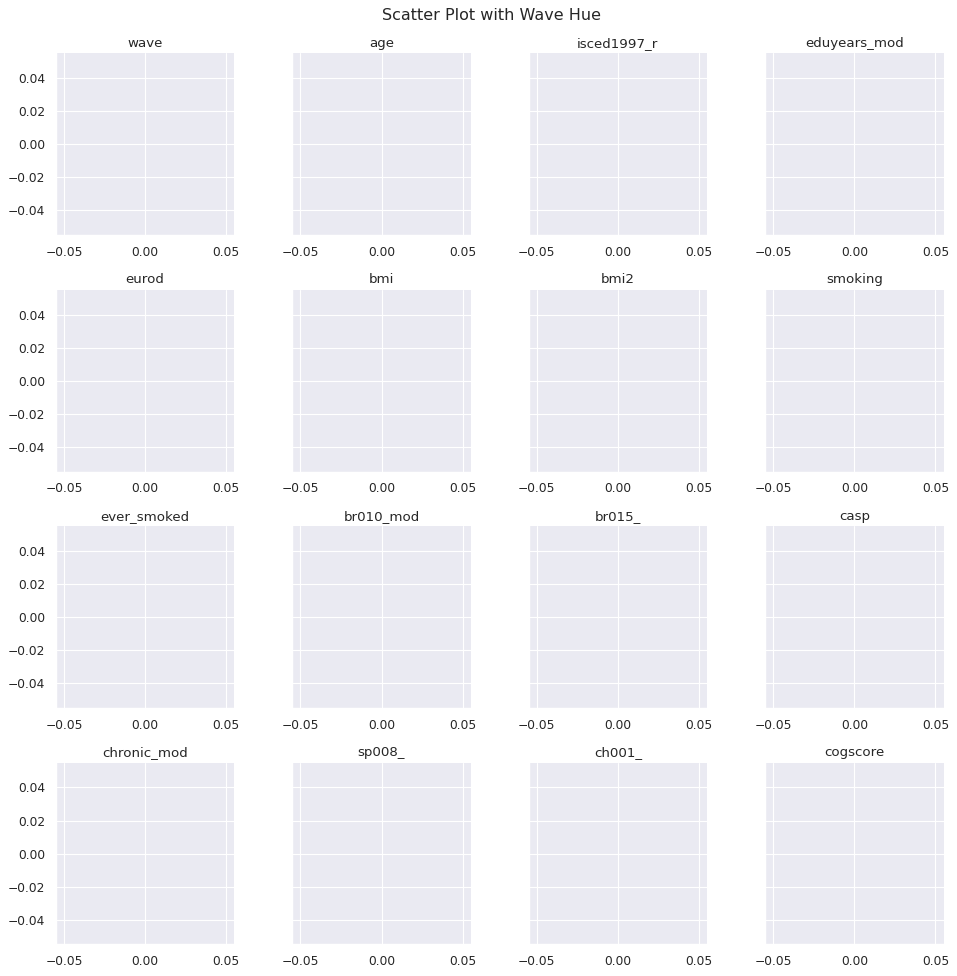

In [89]:
# "Pairplot" equivalent
cols_comp = df.columns.values.tolist()
unwanted_cols=['mergeid','country_inc','int_year','country','country_mod',
                  'female','birth_country','citizenship']
new_cols=[x for x in cols_comp if x not in unwanted_cols]
#new_cols
# cat_cols_f=cat_vars+['female','wave']
# cat_cols_f.remove('country_inc')
# lst_cols_f=lst_cols+['female']
# std_df = pd.concat([nc_df_std, df[cat_cols_f]], axis="columns")
#     # Creating Facet Grid
g = sns.FacetGrid(pd.DataFrame(new_cols), col=0, col_wrap=4, sharex=False)
    # Plotting scatterplots
for ax, varx in zip(g.axes, new_cols):
    sns.scatterplot(data=cap_df[(cap_df['wave'] == 1)],
                    x=varx, y="cogscore", ax=ax,alpha=0.3)
    ax.set_xlabel("")

g.set_titles('{col_name}')
plt.suptitle('Scatter Plot with Wave Hue', y=1.015)
# g.tight_layout()

## EXPLORE USING THIS! Wave 1/2 have a little more clear relationships?
## TRY adding a country filter.

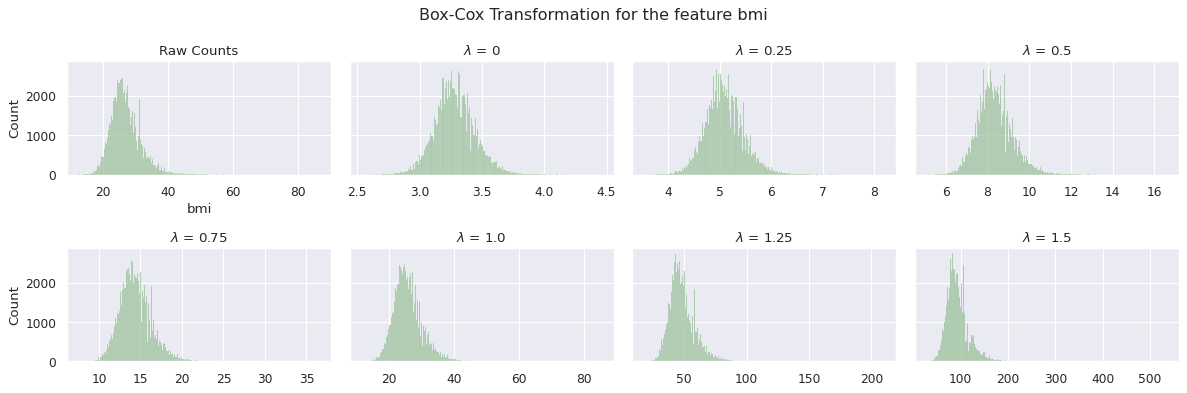

In [17]:
# FEATURE ENGINEERING - DATA TRANSFORMATION

# Box-Cox transformation to normalize the data
fig, axes = plt.subplots(figsize = (15,5), ncols = 4, nrows=2, sharey = True)
axes = axes.flatten()
sns.histplot(data = df['bmi'], ax = axes[0], color='#95bd95')
axes[0].set_title("Raw Counts")

for i, lmbda in enumerate([0, 0.25, 0.5, 0.75, 1., 1.25, 1.5]):
    
    house_box_ = stats.boxcox(df['bmi'].astype(float), lmbda = lmbda)
    sns.histplot(data = house_box_, ax = axes[i + 1],color='#95bd95')
    axes[i + 1].set_title("$\lambda$ = {}".format(lmbda))

fig.suptitle("Box-Cox Transformation for the feature bmi")
plt.tight_layout()
plt.show()

In [35]:
# Finding optimal lambda for non-normal variables.
age_box_,bc_age_param = stats.boxcox(cap_df['age'].astype(int), lmbda = None)
print(f'The lambda that maximizes the log-likelihood function for the variable age is {round(bc_age_param,2)}.')

cs_box_,bc_cs_param = stats.boxcox(cap_df['cogscore'].astype(float), lmbda = None)
print(f'The lambda that maximizes the log-likelihood function for the variable cogscore is {round(bc_cs_param,2)}.')

casp_box_,bc_casp_param = stats.boxcox(cap_df['casp'].astype(float), lmbda = None)
print(f'The lambda that maximizes the log-likelihood function for the variable casp is {round(bc_casp_param,2)}.')

bmi_box_,bc_bmi_param = stats.boxcox(cap_df['bmi'].astype(float), lmbda = None)
print(f'The lambda that maximizes the log-likelihood function for the variable bmi is {round(bc_bmi_param,2)}.')

The lambda that maximizes the log-likelihood function for the variable age is -1.56.
The lambda that maximizes the log-likelihood function for the variable cogscore is 1.06.
The lambda that maximizes the log-likelihood function for the variable casp is 2.04.
The lambda that maximizes the log-likelihood function for the variable bmi is -0.52.


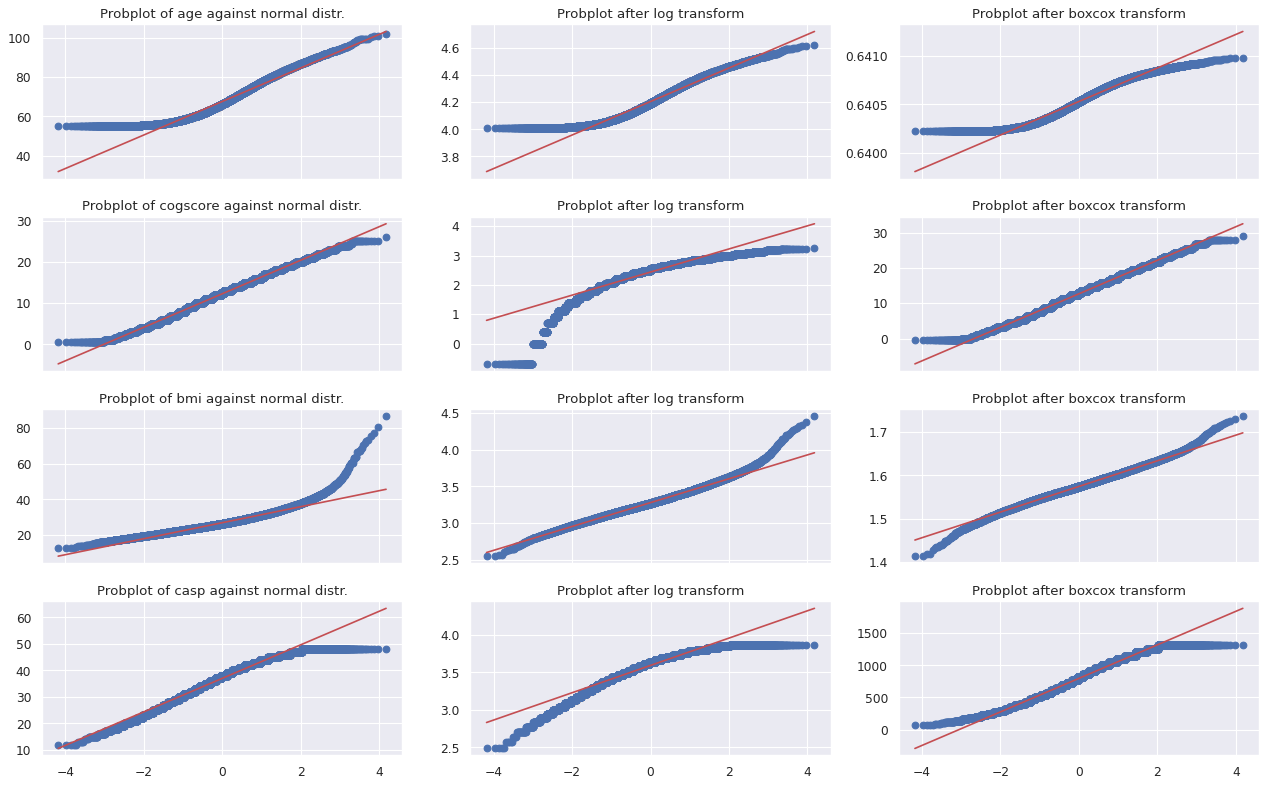

In [37]:
# adapted from Feature Engineering for Machine Learning principles and 
# techniques for data scientists
list_bc=['age','cogscore','bmi','casp']
cols_bc = cap_df[list_bc]
opt_lmbdas=[bc_age_param,bc_cs_param,bc_bmi_param,bc_casp_param]
fig2, axs = plt.subplots(4,3, figsize=(16,10), sharex=True) 

for i in range(len(axs)):
    prob1 = stats.probplot(cols_bc[list_bc[i]].astype(float), dist=stats.norm, plot=axs[i][0])
    axs[i][0].set_xlabel('')
    axs[i][0].set_ylabel('') 
    axs[i][0].set_title(f'Probplot of {list_bc[i]} against normal distr.') 

    house_box_ = stats.boxcox(cols_bc[list_bc[i]].astype(float), lmbda=0.)
    prob2 = stats.probplot(house_box_, dist=stats.norm, plot=axs[i][1]) 
    axs[i][1].set_xlabel('') 
    axs[i][1].set_ylabel('') 
    axs[i][1].set_title('Probplot after log transform')

    house_box_ = stats.boxcox(cols_bc[list_bc[i]].astype(float), lmbda=opt_lmbdas[i])
    prob3 = stats.probplot(house_box_, dist=stats.norm, plot=axs[i][2]) 
    axs[i][2].set_xlabel('') 
    axs[i][2].set_ylabel('') 
    axs[i][2].set_title('Probplot after boxcox transform')

plt.tight_layout()
plt.show()



From these variables, it is evident *bmi* is the only variable benefiting from a Box-Cox transformation, while the rest (*cogscore*, *age* and *casp*) get farther away from a normal distribution with both log-transformation and Box-Cox transformation with $\lambda$ ≠ 0.

In [38]:
# Data Transformation
# print(df['smoked'].value_counts())
    # Replacing smoking value 5 (non-smoker) for 0.
for i in bin_vars:
    cap_df[i]=np.where(cap_df[i]==5,
                            0,cap_df[i])

bmi2_vals=['underweight','normal','overweight','obese']
br010_vals=['no_drink','less1mo_drink','cple1mo_drink','cple1wk_drink',
            '4wk_drink','6wk_drink','daily_drink']
br015_vals=['more1wk_act','1wk_act','mnthly_act','hardly_act']

cap_df['bmi2']=np.where(cap_df['bmi2'].astype(int)==1,
                        bmi2_vals[0],
                        np.where(cap_df['bmi2'].astype(int)==2,
                        bmi2_vals[1],
                        np.where(cap_df['bmi2'].astype(int)==3,
                        bmi2_vals[2],
                        bmi2_vals[3])))

cap_df['br015_']=np.where(cap_df['br015_'].astype(int)==1,
                        br015_vals[0],
                        np.where(cap_df['br015_'].astype(int)==2,
                        br015_vals[1],
                        np.where(cap_df['br015_'].astype(int)==3,
                        br015_vals[2],
                        br015_vals[3])))

cap_df['br010_mod']=np.where(cap_df['br010_mod'].astype(int)==1,
                        br010_vals[0],
                        np.where(cap_df['br010_mod'].astype(int)==2,
                        br010_vals[1],
                        np.where(cap_df['br010_mod'].astype(int)==3,
                        br010_vals[2],
                        np.where(cap_df['br010_mod'].astype(int)==4,
                        br010_vals[3],
                        np.where(cap_df['br010_mod'].astype(int)==5,
                        br010_vals[4],
                        np.where(cap_df['br010_mod'].astype(int)==6,
                        br010_vals[5],
                        br010_vals[6]))))))



In [79]:
from sklearn.model_selection import train_test_split

# DATA PARTITIONING

# Set a seed for reproducibility of results
rng = np.random.seed(21701)

# First split off features and targets
# X = df.drop(['mergeid', 'cogscore'], axis = 1) # Set of features
baseline_features = ['eduyears_mod', 'bmi2','smoking','br010_mod', 'br015_',
                    'casp','age','sp008_']
cap_df_w5=cap_df[(cap_df['wave'] == 5)]
X = cap_df_w5[baseline_features]
y = cap_df_w5['cogscore']

# We shuffle the data so the countries get mixed up
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rng)

# Do we want to do 80-10-10 to include a validation set? 
# Alternatively, we do CV in the end which may be better
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rng)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

print('X_train:', X_train.shape)
print('y_train:', y_train.shape)

print("X_test:", X_test.shape)
print("y_test:", y_test.shape)
X_train
# print("X_val:", X_val.shape)
# print("y_val:", y_val.shape)

X_train: (8276, 8)
y_train: (8276,)
X_test: (2070, 8)
y_test: (2070,)


,eduyears_mod,bmi2,smoking,br010_mod,br015_,casp,age,sp008_
92045,11.0,2.0,1.0,5.0,1.0,45.0,59.500000,5.0
73785,15.0,3.0,5.0,5.0,4.0,40.0,66.400002,5.0
81078,14.0,2.0,5.0,2.0,2.0,38.0,73.599998,1.0
31776,20.0,2.0,5.0,4.0,2.0,38.0,71.400002,1.0
29139,11.0,4.0,5.0,4.0,2.0,34.0,62.299999,5.0
...,...,...,...,...,...,...,...,...
64305,11.0,2.0,1.0,7.0,4.0,31.0,73.000000,5.0
31701,10.0,3.0,1.0,4.0,1.0,48.0,60.500000,1.0
92641,8.0,3.0,5.0,4.0,1.0,39.0,65.300003,1.0
64244,5.0,3.0,5.0,1.0,4.0,26.0,74.400002,5.0


# Model Fitting and Tuning

*In this section you should detail your choice of model and describe the process used to refine and fit that model. You are strongly encouraged to explore many different modeling methods (e.g. linear regression, interaction terms, lasso, etc.) but you should not include a detailed narrative of all of these attempts. At most this section should mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using and your process for tuning and validating it.*

*For example if you considered a linear regression model, a polynomial regression, and a lasso model and ultimately settled on the linear regression approach then you should mention that other two approaches were tried but do not include any of the code or any in depth discussion of these models beyond why they were rejected. This section should then detail is the development of the linear regression model in terms of features used, interactions considered, and any additional tuning and validation which ultimately led to your final model.* 

*This section should also include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.*

*Finally, you should also provide comparison of your model with baseline model(s) on the test data but only briefly describe the baseline model(s) considered*

We will build our model from the ground up. Given the scatterplots did not show any obvious relationship between the variables, we use the information shown by the correlation matrices and the previous literature as reference, starting off with a model that includes obesity, smoking, education, drinking behavior, physical activity level, quality of life and age as predictors.

In [80]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
# Baseline model

num_pre = Pipeline([
    ("num_scale", MinMaxScaler())])

cat_pre = Pipeline([
    ("cat_encode", OneHotEncoder(drop='first'))])

# br010_cat_pre = Pipeline([
#     ("br010_encode", OneHotEncoder(drop=np.array(['no_drink'])))])

# br015_cat_pre = Pipeline([
#     ("br015_encode", OneHotEncoder(drop=np.array(['more1wk_act'])))])

reg_pipe_1 = Pipeline([
    ("pre_processing", ColumnTransformer([("num_pre", num_pre, [0,2,5,6,7]),
                                          ("cat_pre", cat_pre, [1,3,4])])),
    ("model", LinearRegression())
])

reg_pipe_1

lm0=reg_pipe_1.fit(X_train,y_train)
# # Print the R squared (ranges 0 to 1, with higher values better)
print(round(reg_pipe_1.score(X_train, y_train), 3))
# coef_series = pd.Series(
#   data=get_coefs(lm0),
#   index=['intercept' , *lm0[:-1].get_feature_names_out()]
# )

# model_fit(lm0, X_train, y_train, plot = True)
# print(coef_series)

# lm = LinearRegression().fit(X_train, y_train)
# print(round(lm.score(X_train, y_train), 3))

# print(np.c_[np.append(['intercept'],lm.feature_names_in_),np.round(get_coefs(lm),4)])

# # Model fit on training data
# model_fit(lm, X_train, y_train, plot = True)

# # Model fit on test data
# # model_fit(lm, X_test, y_test, plot = True)

0.338


Clearly a our baseline model is not reliable to assess the relationship between our independent variables and our dependent variable, *cogscore*. We will proceed to estimate a log-log regression model, which is generally considered better to assess non-linear relationships between variables.

In [ ]:
# Linear regression with standardised numerical variable
X_ = df.drop(['mergeid', 'cogscore'], axis = 1) # Set of features
y = df['cogscore']

# We shuffle the data so the countries get mixed up
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.3, random_state=rng)

lr_pipeline = Pipeline([
    ("pre_processing", ColumnTransformer([("num", StandardScaler(), numerical_vars),
                                          ("cat", "passthrough", bin_vars+cat_vars)])),
    ("model", LinearRegression())
])

lr_pipeline

linear_model = lr_pipeline.fit(X_train, y_train)

# print(np.c_[np.append(['intercept'],linear_model.feature_names_in_),np.round(get_coefs(linear_model),4)])

# Model fit on training data
model_fit(linear_model, X_train, y_train, plot = True)

# Model fit on test data
model_fit(linear_model, X_test, y_test, plot = True)



ValueError: A given column is not a column of the dataframe

In [ ]:
pf = PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)

# Overall ML pipeline
reg_pipe = Pipeline([
    ("interact", pf),
    ("model", LinearRegression())
])

lm_poly = reg_pipe.fit(X_train, y_train)


# Model fit on training data
model_fit(lm_poly, X_train, y_train, plot = True)

# Model fit on test data
model_fit(lm_poly, X_test, y_test, plot = True)

# print(reg_pipe.named_steps['model'].coef_)
# print(reg_pipe.steps[2][1].intercept_)

# # Extract the names of the features
# names_fe1 = reg_pipe['pre_processing'].get_feature_names_out()
# # print(names_fe1)
# print(reg_pipe['interact'].get_feature_names_out(names_fe1))

[['intercept' 12.3056]
 ['int_year' -0.6083]
 ['wave' 1.0217]
 ['country' -0.1314]
 ['country_mod' -0.0531]
 ['female' 0.4197]
 ['age' -1.0342]
 ['birth_country' -0.0546]
 ['citizenship' -0.1298]
 ['isced1997_r' 0.9901]
 ['eduyears_mod' 0.4032]
 ['eurod' -0.4133]
 ['bmi' 0.0302]
 ['bmi2' -0.0094]
 ['smoking' 0.0963]
 ['ever_smoked' -0.1277]
 ['br010_mod' 0.1518]
 ['br015_' -0.22]
 ['casp' 0.4437]
 ['chronic_mod' 0.0412]
 ['sp008_' -0.2053]
 ['ch001_' -0.0259]]


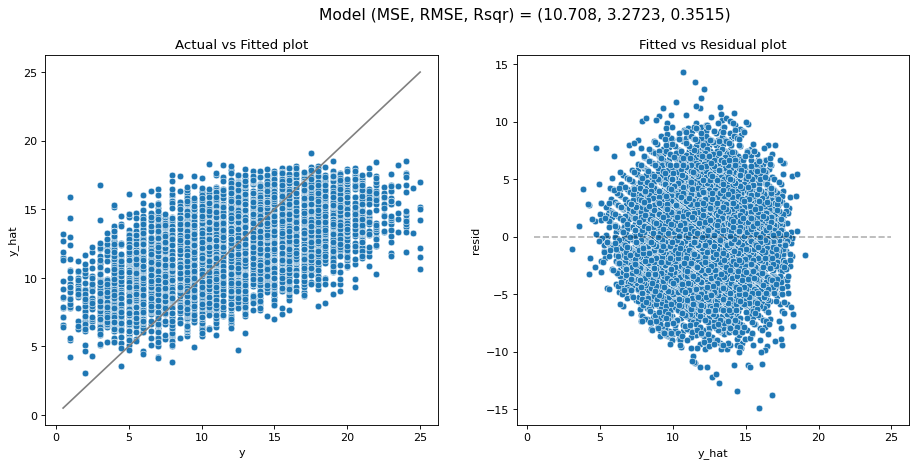

Text(0.5, 0, 'Alpha')

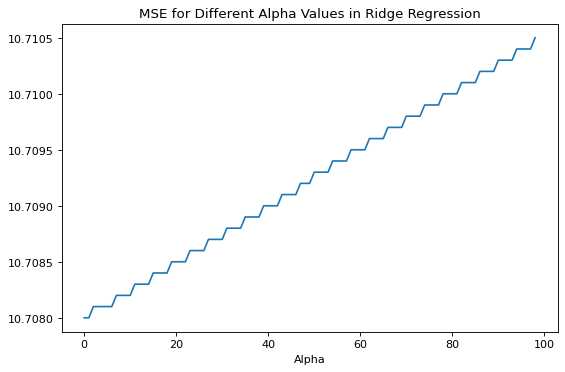

In [ ]:
# Selected alpha value 
alpha_val = 1

r = make_pipeline(
    StandardScaler(),
    Ridge(alpha = alpha_val)
).fit(X_train, y_train)

print(np.c_[np.append(['intercept'],r.feature_names_in_),np.round(get_coefs(r),4)])

model_fit(r, X_test, y_test, plot = True)

alpha_val = np.arange(1, 100, 1)
MSE = []

# why the fuck does this look like this? it keeps decreasing so no local minimum?!
for alpha in alpha_val:
    r = make_pipeline(
        StandardScaler(),
        Ridge(alpha = alpha)
    ).fit(X_train, y_train)

    MSE.append(model_fit(r, X_test, y_test)[0])

plt.plot(MSE)
plt.title("MSE for Different Alpha Values in Ridge Regression")
plt.xlabel("Alpha")



# Discussion & Conclusions

*In this section you should provide a general overview of your final model, its performance, and reliability. You should discuss what the implications of your model are in terms of the included features, predictive performance, and anything else you think is relevant.*

*This should be written with a target audience of a government official or charity directy, who is understands the pressing challenges associated with ageining and dementia but may only have university level mathematics (not necessarily postgraduate statistics or machine learning). Your goal should be to highlight to this audience how your model can useful. You should also mention potential limitations of your model.*

*Finally, you should include recommendations on potential lifestyle changes or governmental/societal interventions to reduce dementia risk.*

*Keep in mind that a negative result, i.e. a model that does not work well predictively, that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explinations / justifications.*

# References

*Include references if any*

In [ ]:
# Run the following to render to PDF
!jupyter nbconvert --to pdf project1.ipynb

[NbConvertApp] Converting notebook project1.ipynb to pdf
[NbConvertApp] ERROR | Error while converting 'project1.ipynb'
Traceback (most recent call last):
  File "/home/codespace/.local/lib/python3.10/site-packages/nbconvert/nbconvertapp.py", line 487, in export_single_notebook
    output, resources = self.exporter.from_filename(
  File "/home/codespace/.local/lib/python3.10/site-packages/nbconvert/exporters/templateexporter.py", line 386, in from_filename
    return super().from_filename(filename, resources, **kw)  # type:ignore[return-value]
  File "/home/codespace/.local/lib/python3.10/site-packages/nbconvert/exporters/exporter.py", line 201, in from_filename
    return self.from_file(f, resources=resources, **kw)
  File "/home/codespace/.local/lib/python3.10/site-packages/nbconvert/exporters/templateexporter.py", line 392, in from_file
    return super().from_file(file_stream, resources, **kw)  # type:ignore[return-value]
  File "/home/codespace/.local/lib/python3.10/site-packages/